In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Dataset/Better
!git clone  https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git
!ls

/content/drive/My Drive/Dataset/Better
fatal: destination path 'indic_nlp_resources' already exists and is not an empty directory.
fatal: destination path 'indic_nlp_library' already exists and is not an empty directory.
clean_english-hindi-both.pkl   English_large_modified.txt  indic_nlp_resources
clean_english-hindi.pkl        Fonts			   saved_model_weights
clean_english-hindi-test.pkl   Hindi_large_modified.txt    training_checkpoints
clean_english-hindi-train.pkl  indic_nlp_library


In [3]:
import sys
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"/content/drive/My Drive/Dataset/Better/indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"/content/drive/My Drive/Dataset/Better/indic_nlp_resources"

sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize
from indicnlp.transliterate.unicode_transliterate import ItransTransliterator

In [4]:
%tensorflow_version 2.x
import os
import string
import numpy as np
from numpy.random import rand, shuffle
import pandas as pd
from string import digits
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
%matplotlib inline
import re
import logging
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
from pickle import dump, load
import io
import time
import warnings
import sys
from unicodedata import normalize
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

## Preprocess English and Hindi sentences

In [5]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'), protocol=4)
    print('Saved: %s' % filename)

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def load_doc(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

def to_pairs(english_text, hindi_text):
    english_lines = english_text.strip().split('\n')
    hindi_lines = hindi_text.strip().split('\n')
    pairs = []
    for i in range(len(hindi_lines)):
        pairs.append([])
        pairs[i].append(pre_process_english_sentence(english_lines[i]))
        pairs[i].append(pre_process_hindi_sentence(hindi_lines[i]))
    return pairs

def clean_text(text):
    text = text.replace(u',',' ')
    text = text.replace(u'"','')
    text = text.replace(u'"','')
    text = text.replace(u"‘‘",'')
    text = text.replace(u"’’",'')
    text = text.replace(u"''",'')
    text = text.replace(u"।",' ')
    text=text.replace(u',',' ')
    text=text.replace(u'"',' ')
    text=text.replace(u'(',' ')
    text=text.replace(u')',' ')
    text=text.replace(u'"',' ')
    text=text.replace(u':',' ')
    text=text.replace(u"'",'')
    text=text.replace(u"‘‘",' ')
    text=text.replace(u"’’",' ')
    text=text.replace(u"''",' ')
    text=text.replace(u".",' ')
    text=text.replace(u"-",' ')
    text=text.replace(u"।",' ')
    text=text.replace(u"?",' ')
    text=text.replace(u"\\",' ')
    text=text.replace(u"_",' ')
    text=text.replace("'", "")
    text=text.replace('"', "")
    text= re.sub("'", '', text)
    text= re.sub("’", '', text)
    text=re.sub('[0-9+\-*/.%]', ' ', text)
    text=text.strip()
    text=re.sub(' +', ' ',text)
    exclude = set(string.punctuation)
    text= ''.join(ch for ch in text if ch not in exclude)
    return text

def pre_process_english_sentence(line):
    line = line.lower()
    line = clean_text(line)
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    line = line.split()
    line = [re_print.sub('', w) for w in line]
    line = [word for word in line if word.isalpha()]
    line = ' '.join(line)
    line = '<start> '+ line + ' <end>'
    return line

def pre_process_hindi_sentence(line):
    line=re.sub('[a-zA-Z]', '', line)
    line = clean_text(line)
    remove_nuktas = False
    factory = IndicNormalizerFactory()
    normalizer = factory.get_normalizer("hi")
    line = normalizer.normalize(line)
    tokens = list()
    for t in indic_tokenize.trivial_tokenize(line):
        tokens.append(t)
    line = tokens
    line = [word for word in line if not re.search(r'\d', word)]
    line = ' '.join(line)
    # line = ItransTransliterator.to_itrans(line, 'hi')
    line = '<start> '+ line + ' <end>'
    return (line)

In [10]:
english_text = load_doc('English_large_modified.txt')
hindi_text = load_doc('Hindi_large_modified.txt')
pairs = to_pairs(english_text, hindi_text)
clean_pairs = np.array(pairs)
save_clean_data(clean_pairs, 'clean_english-hindi.pkl')

Saved: clean_english-hindi.pkl


In [11]:
clean_pairs[2363]

array(['<start> i like the blue one how much does it cost <end>',
       '<start> मुझे नीली वाली पसंद है कितने की है <end>'], dtype='<U112')

In [12]:
def prepare_dataset(dataset_path, dataset_size=None):
  raw_dataset = load_clean_sentences(dataset_path)
  if dataset_size==None:
    dataset_size = len(raw_dataset)
  n_sentences = dataset_size
  n_train = (int)(n_sentences*80/100)
  dataset = raw_dataset[:n_sentences, :]

  train, test = dataset[:n_train], dataset[n_train:]

  save_clean_data(dataset, 'clean_english-hindi-both.pkl')
  save_clean_data(train, 'clean_english-hindi-train.pkl')
  save_clean_data(test, 'clean_english-hindi-test.pkl')

In [13]:
# Try experimenting with the size of that dataset
prepare_dataset('clean_english-hindi.pkl', 150000)

Saved: clean_english-hindi-both.pkl
Saved: clean_english-hindi-train.pkl
Saved: clean_english-hindi-test.pkl


In [14]:
dataset = load_clean_sentences('clean_english-hindi-both.pkl')
train = load_clean_sentences('clean_english-hindi-train.pkl')
test = load_clean_sentences('clean_english-hindi-test.pkl')

shuffle(dataset)
shuffle(train)
shuffle(test)

In [15]:
def load_dataset(pairs):  
    inp_lang = LanguageIndex(en for en, hi in pairs)
    targ_lang = LanguageIndex(hi for en, hi in pairs)
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, hi in pairs]
    target_tensor = [[targ_lang.word2idx[s] for s in hi.split(' ')] for en, hi in pairs]
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    return inp_lang, targ_lang, max_length_inp, max_length_tar

inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(dataset)

In [17]:
def train_tensor(pairs, max_length_inp, max_length_tar, inp_lang, targ_lang):
    input_tensor_x = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, hi in pairs]
    target_tensor_y = [[targ_lang.word2idx[s] for s in hi.split(' ')] for en, hi in pairs]
    input_tensor_x = tf.keras.preprocessing.sequence.pad_sequences(input_tensor_x, maxlen=max_length_inp, padding='post')
    target_tensor_y = tf.keras.preprocessing.sequence.pad_sequences(target_tensor_y, maxlen=max_length_tar, padding='post')
    return input_tensor_x, target_tensor_y

input_tensor_train, target_tensor_train = train_tensor(train, max_length_inp, max_length_targ, inp_lang, targ_lang)
input_tensor_val, target_tensor_val = train_tensor(test, max_length_inp, max_length_targ, inp_lang, targ_lang)

In [18]:
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(120000, 120000, 30000, 30000)

In [20]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.idx2word[t]))

In [21]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[7])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[7])

Input Language; index to word mapping
3 ----> <start>
333 ----> accordingly
21393 ----> it
47031 ----> was
29324 ----> now
10629 ----> decided
43828 ----> to
38580 ----> send
26327 ----> me
43828 ----> to
6362 ----> calcutta
2 ----> <end>

Target Language; index to word mapping
2 ----> <start>
7857 ----> उसी
30386 ----> निश्चय
13065 ----> के
45489 ----> मुताबिक
46165 ----> मेरा
10992 ----> कलकत्ता
21147 ----> जाना
20742 ----> जल्दी
62868 ----> ही
25055 ----> तय
32934 ----> पा
15971 ----> गया
1 ----> <end>


In [22]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 64
units = 128
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Encoder Decoder with Attention Model

> Encoder Decoder with Attention model is a general end-to-end approach to sequence learning that makes minimal assumptions on the sequence structure. It uses a multilayered Gated Recurrent Unit (GRU) to map the input sequence to a vector of a fixed dimensionality, and then another deep GRU to decode the target sequence from the vector.
<img src="https://www.researchgate.net/profile/Vlad_Zhukov2/publication/321210603/figure/fig1/AS:642862530191361@1530281779831/An-example-of-sequence-to-sequence-model-with-attention-Calculation-of-cross-entropy.png" width="800" alt="attention mechanism">

> A sequence to sequence model has two parts – an encoder and a decoder. Both the parts are practically two different neural network models combined into one giant network. the task of an encoder network is to understand the input sequence, and create a smaller dimensional representation of it. This representation is then forwarded to a decoder network which generates a sequence of its own that represents the output. The input is put through an encoder model which gives us the encoder output. Here, each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. We use Bahdanau attention for the encoder.



### Encoder

In [23]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru_h1 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    x = self.gru_h1(x, initial_state = hidden)
    output, state = self.gru(x)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

### Attention Mechanism

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

### Decoder

In [52]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru_h1 = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    x = self.gru_h1(x)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [53]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [50]:
print(encoder.summary())
print(decoder.summary())

Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  3085376   
_________________________________________________________________
gru_4 (GRU)                  multiple                  99072     
_________________________________________________________________
gru_5 (GRU)                  multiple                  74496     
Total params: 3,258,944
Trainable params: 3,258,944
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  4074560   
_________________________________________________________________
gru_6 (GRU)                  multiple                  99072     
_______________________

### Optimizer

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
#   print(type(mask))
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

>1. Pass *input* through *encoder* to get *encoder output*..
>2. Then encoder output, encoder hidden state and the decoder input is passed to decoder.
>3. Decoder returns *predictions* and *decoder hidden state*.
>4. Decoder hidden state is then passed back to model.
>5. Predictions are used to calculate loss.
>6. Use *teacher forcing* (technique where the target word is passed as the next input to the decoder) for the next input to the decoder.
>7. Calculate gradients and apply it to *optimizer* for backpropogation.

In [33]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
    # Teacher forcing
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))      
  return batch_loss

In [34]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5837
Epoch 1 Batch 100 Loss 3.1380
Epoch 1 Batch 200 Loss 2.9555
Epoch 1 Batch 300 Loss 2.9792
Epoch 1 Batch 400 Loss 3.0598
Epoch 1 Batch 500 Loss 2.9903
Epoch 1 Batch 600 Loss 2.8687
Epoch 1 Batch 700 Loss 2.8128
Epoch 1 Batch 800 Loss 2.8744
Epoch 1 Batch 900 Loss 2.8753
Epoch 1 Loss 2.9632
Time taken for 1 epoch 390.5985233783722 sec

Epoch 2 Batch 0 Loss 2.7638
Epoch 2 Batch 100 Loss 2.5666
Epoch 2 Batch 200 Loss 2.6197
Epoch 2 Batch 300 Loss 2.6345
Epoch 2 Batch 400 Loss 2.6192
Epoch 2 Batch 500 Loss 2.6831
Epoch 2 Batch 600 Loss 2.5609
Epoch 2 Batch 700 Loss 2.5410
Epoch 2 Batch 800 Loss 2.5582
Epoch 2 Batch 900 Loss 2.5931
Epoch 2 Loss 2.5879
Time taken for 1 epoch 348.2093560695648 sec

Epoch 3 Batch 0 Loss 2.3534
Epoch 3 Batch 100 Loss 2.3866
Epoch 3 Batch 200 Loss 2.5353
Epoch 3 Batch 300 Loss 2.5281
Epoch 3 Batch 400 Loss 2.3465
Epoch 3 Batch 500 Loss 2.3883
Epoch 3 Batch 600 Loss 2.4265
Epoch 3 Batch 700 Loss 2.2899
Epoch 3 Batch 800 Loss 2.3246
Epoc

KeyboardInterrupt: ignored

In [35]:
def evaluate(sentence, encoder=encoder, decoder=decoder, inp_lang=inp_lang, targ_lang=targ_lang, max_length_inp=max_length_inp, max_length_targ=max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = pre_process_english_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_inp,
                                                          padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
      predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                          dec_hidden,
                                                          enc_out)

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()
      predicted_id = tf.argmax(predictions[0]).numpy()
      result += targ_lang.idx2word[predicted_id] + ' '

      if targ_lang.idx2word[predicted_id] == '<end>':
        return result, sentence, attention_plot

      # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [36]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [37]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [38]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> how much does this cost <end>
Predicted translation: क्या इस प्रकार के लिए <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2311 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s

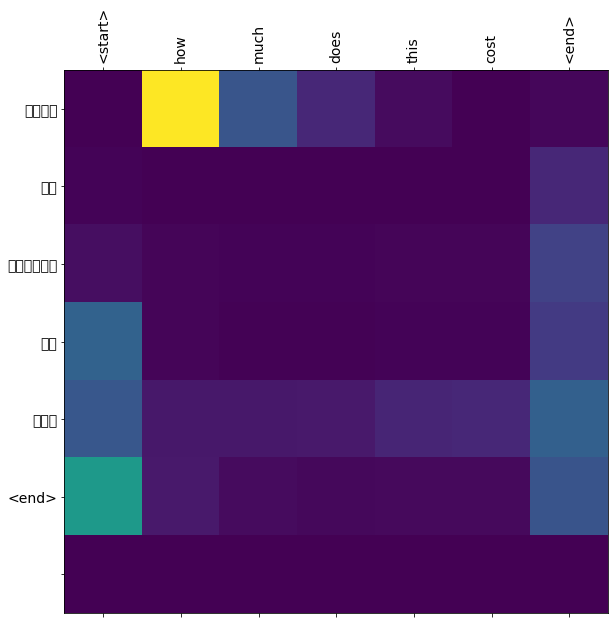

In [39]:
translate(u'how much does this cost?')

Input: <start> you are my friend <end>
Predicted translation: मैं तुम्हें कोई <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s

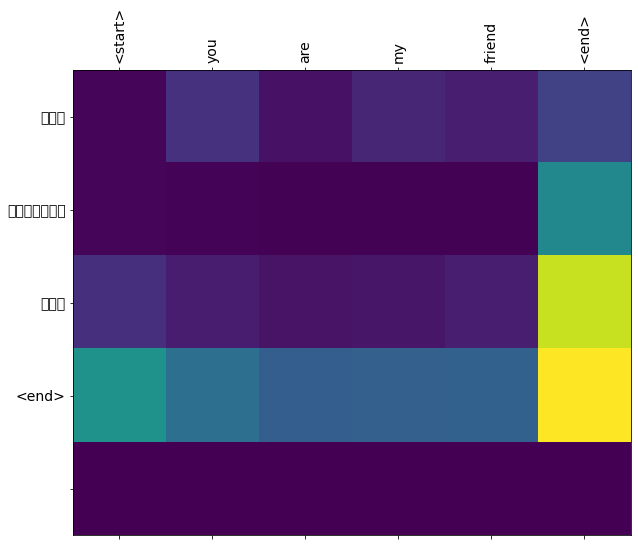

In [40]:
translate(u'you are my friend.')